In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [35]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import lal
import lalsimulation as ls
import multiprocessing as multi
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.optimize import linprog
import seaborn as sns
from tqdm import tqdm_notebook

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

The mass distribution is 
$$
p\left( m_1 \right) \propto \frac{1}{m_1}
$$
(flat in log primary mass) with 
$$
p\left( m_2 \mid m_1 \right) \propto \mathrm{const}
$$
(flat in mass ratio at fixed $m_1$) with $5 \, M_\odot \leq m_2 \leq m_1 \leq 50 \, M_\odot$.

The precise mass distribution doesn't matter much for the selection function on $\chi_\mathrm{eff}$; as long as there aren't very sharp features in the $q$ distribution the selection function comes out pretty much the same.

In [3]:
MMin = 5
MMax = 50

def draw_m1m2(size=1):
    u1s = np.random.uniform(size=size)
    u2s = np.random.uniform(size=size)
    
    m1s = exp(u1s*log(MMax) + (1-u1s)*log(MMin))
    m2s = m1s*u2s + MMin*(1-u2s)
    
    return (m1s, m2s)

def p_m1m2(m1, m2):
    return 1/m1/(log(MMax/MMin))/(m1 - MMin)

We draw mergers that follow the low-redshift star-formation rate.  $z_\mathrm{max}$ is close to the correct value for design sensitivity; it can be reduced considerably for early sensitivity.

In [40]:
gamma = 2.7
zMax = 2.1

zs = expm1(linspace(log(1), log(1+zMax), 1024))
dNdz = (1+zs)**(gamma-1)*4*pi*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value
Nz = cumtrapz(dNdz, zs, initial=0)

icdf_z = interp1d(Nz/Nz[-1], zs)
p_z = interp1d(zs, dNdz/Nz[-1])

def draw_z(size=1):
    return icdf_z(np.random.uniform(size=size))

Uniform on the sky:

In [41]:
def draw_ra_dec(size=1):
    ra = np.random.uniform(low=0, high=2*pi, size=size)
    sin_dec = np.random.uniform(low=-1, high=1, size=size)
    
    return ra, arcsin(sin_dec)

Drawn flat in $-1 < \chi_\mathrm{eff} < 1$.

In [42]:
def draw_chieff(size=1):
    return np.random.uniform(low=-1, high=1, size=size)

This is the code that actually generates the mergers and down-selects them according to an SNR threshold.  Notable bits:

* If you change the `psd` argument in `compute_detector_snrs`, you can operate at "early" sensitivity (i.e. O1+O2 sensitivity).
* The `approx_det_cut` function is intended to reject hopeless signals by drawing a line in the $m_1$-$z$ plane that can quickly eliminate signals with masses too small to be detectable (so we don't have to generate their waveforms; this is particularly helpful because low-mass waveforms from $\sim 10 \, \mathrm{Hz}$ are very long, so computationally expensive to generate).  **It is not curretly properly tuned, however, so will reject detectable signals.**  (This is likely not a major issue with $\chi_\mathrm{eff}$ selection effects, but we should check that.

In [65]:
fmin = 9.0
fref = 40.0
psdstart = 10.0

snr_thresh = 8*sqrt(2) # 8 in at least two detectors

def next_pow_two(x):
    x2 = 1
    while x2 < x:
        x2 = x2 << 1
    
    return x2

def generate_waveform(m1, m2, chi_eff, z):
    dL = cosmo.Planck15.luminosity_distance(z).to(u.Gpc).value
        
    tmax = ls.SimInspiralChirpTimeBound(fmin, m1*(1+z)*lal.MSUN_SI, m2*(1+z)*lal.MSUN_SI, 0.0, 0.0) + 2
    
    df = 1.0/next_pow_two(tmax)
    fmax = 2048.0 # Hz --- based on max freq of 5-5 inspiral
    
    cos_i = np.random.uniform(low=-1, high=1)
    phi_ref = np.random.uniform(low=0, high=2*pi)
    
    hp, hc = ls.SimInspiralChooseFDWaveform((1+z)*m1*lal.MSUN_SI, (1+z)*m2*lal.MSUN_SI, 0.0, 0.0, chi_eff, 0.0, 0.0, chi_eff, dL*1e9*lal.PC_SI, arccos(cos_i), phi_ref, 0.0, 0.0, 0.0, df, fmin, fmax, fref, None, ls.IMRPhenomPv2)
    
    return hp, hc

def compute_detector_snrs(hp, hc, ra, dec, psd='design'):
    psi = np.random.uniform(low=0, high=2*pi)
    gmst = np.random.uniform(low=0, high=2*pi)
    
    snrs = []
    for det in ['H1', 'L1', 'V1']:
        Fp, Fc = lal.ComputeDetAMResponse(lal.cached_detector_by_prefix[det].response, ra, dec, psi, gmst)
        
        h = lal.CreateCOMPLEX16FrequencySeries("h", lal.LIGOTimeGPS(0), 0.0, hp.deltaF, hp.sampleUnits, hp.data.length)
        h.data.data = Fp*hp.data.data + Fc*hc.data.data
        
        fmax = hp.deltaF*(hp.data.length - 1)
        df = hp.deltaF
        Nf = hp.data.length

        fs = linspace(0, fmax, Nf)
        sel = fs > psdstart

        sffs = lal.CreateREAL8FrequencySeries("psds", 0, 0.0, df, lal.DimensionlessUnit, fs.shape[0])
        if det == 'H1' or det == 'L1':
            if psd == 'early':
                ls.SimNoisePSDaLIGOEarlyHighSensitivityP1200087(sffs, psdstart)
            elif psd == 'design':
                ls.SimNoisePSDaLIGOaLIGODesignSensitivityT1800044(sffs, psdstart)
            else:
                raise ValueError('psd must be one of early, design')
        elif det == 'V1':
            if psd == 'early':
                ls.SimNoisePSDAdVEarlyHighSensitivityP1200087(sffs, psdstart)
            elif psd == 'design':
                ls.SimNoisePSDAdVDesignSensitivityP1200087(sffs, psdstart)
            else:
                raise ValueError('psd must be one of early, design')
        else:
            raise ValueError('detector must be one of H1, L1, V1')
        
        rho = ls.MeasureSNRFD(h, sffs, psdstart, -1.0)
        n = randn()
        
        snrs.append(sqrt((rho+n)*(rho+n)))
        
    return array(snrs)

# def approx_det_cut(z):
#     z0 = 0.1
#     m0 = 5
#     z1 = 0.8
#     m1 = 35
    
#     return m1*(z-z0)/(z1-z0) + m0*(z-z1)/(z0-z1)

def approx_det_cut(z):
    m, b = [20.80266868,  -0.9]
    
    return m*z + b

def draw_snr(m1, m2, chi_eff, z, ra, dec):
    if m1 < approx_det_cut(z):
        return (m1, m2, chi_eff, z, ra, dec, 0.0)
    else:
        hp, hc = generate_waveform(m1, m2, chi_eff, z)
        snrs = compute_detector_snrs(hp, hc, ra, dec)
        snr = np.sqrt(np.sum(snrs*snrs))

        return (m1,m2,chi_eff, z,ra,dec,snr)

def draw_snr_onearg(x):
    return draw_snr(*x)

def downselect(m1s, m2s, chi_effs, zs, ras, decs, processes=None):
    m1s_sel = []
    m2s_sel = []
    chi_effs_sel = []
    zs_sel = []
    ras_sel = []
    decs_sel = []
    snrs_sel = []
    
    #s = m1s > approx_mdet_threshold(zs)
    p = multi.Pool(processes=processes)
    try:
        for m1, m2, chi_eff, z, ra, dec, snr in tqdm_notebook(p.imap(draw_snr_onearg, zip(m1s, m2s, chi_effs, zs, ras, decs), chunksize=1024), total=len(zs)):
            if snr > snr_thresh:
                m1s_sel.append(m1)
                m2s_sel.append(m2)
                chi_effs_sel.append(chi_eff)
                zs_sel.append(z)
                ras_sel.append(ra)
                decs_sel.append(dec)
                snrs_sel.append(snr)
    finally:
        p.close()
            
    return array(m1s_sel), array(m2s_sel), array(chi_effs_sel), array(zs_sel), array(ras_sel), array(decs_sel), array(snrs_sel)

To accurately fit a population of size $N$, we need to ensure we can compute the Monte-Carlo selection integral with a fractional uncertainty that is $1/2\sqrt{N}$.  This will require *at least* $4*N$ Monte-Carlo samples (and actually more, because the population we are fitting will not match the draw population, so each M-C sample will not "count fully" and we will have fewer "effective" samples than detected draws).  Conservatively, I chose the number here so that the number of detected samples would be $\mathcal{O}(10 \times 5000)$ so that we can probably analyze a full five years' of design sensitivity (i.e. 5k BBH mergers), though I'm not sure we would want to.

In [70]:
N = 1 << 23
m1s, m2s = draw_m1m2(size=N)
zs = draw_z(size=N)
chi_effs = draw_chieff(size=N)
ras, decs = draw_ra_dec(size=N)

The Monte-Carlo selection function estimate takes about three hours to run on my laptop (four cores):

In [71]:
m1s_sel, m2s_sel, chi_effs_sel, zs_sel, ras_sel, decs_sel, snrs_sel = downselect(m1s, m2s, chi_effs, zs, ras, decs)

Checking that the chosen $z_\mathrm{max}$ doesn't artificially truncate the redshifts of observed sources (it sorta does, but not in a major way).

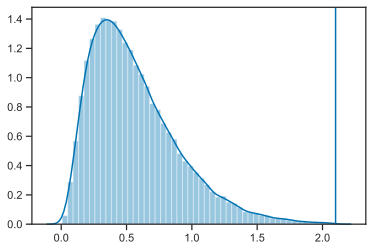

In [72]:
sns.distplot(zs_sel)
axvline(zMax)

Checking the approximate detection threshold; since some sources run up against this line, it needs to be tuned further (or just dropped, but then the runtime of the Monte-Carlo explodes by a factor of 10 or more!).

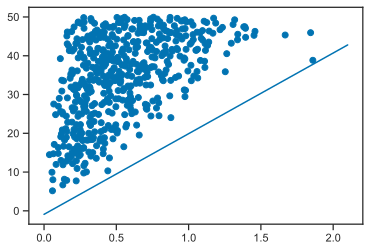

In [78]:
zs = linspace(0, zMax, 1000)
scatter(zs_sel[::100], m1s_sel[::100])
plot(zs, approx_det_cut(zs))

We have about 50k sources.

In [75]:
len(zs_sel)

54366

The code below solves a constrained optimization problem: maximize the area under the approximate selection cut line, subject to the constraint that every observed system lies above it.  **Do not run it on more than ~1k detections, as the computation is expensive.** 

In [59]:
c = -array([0.5*zMax*zMax, zMax])
A_ub = column_stack((zs_sel, ones_like(zs_sel)))
b_ub = m1s_sel

sol = linprog(c, A_ub, b_ub, bounds=[(0, None), (None, None)])
sol

     con: array([], dtype=float64)
     fun: -51.203880379825996
 message: 'Optimization terminated successfully.'
     nit: 10
   slack: array([36.31717905, 16.43145598, 18.94572281, ..., 15.44424398,
        4.66824049, 13.13136789])
  status: 0
 success: True
       x: array([23.11407631,  0.11302005])

In [60]:
0.9*(sol.x)

array([20.80266868,  0.10171805])

Here we finally come to the selection function: $p\left( \chi_eff \mid \mathrm{detected} \right)$:

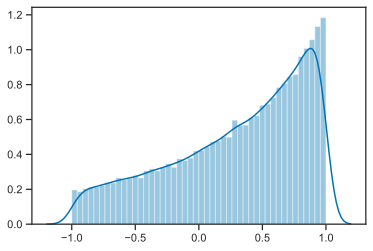

In [79]:
sns.distplot(chi_effs_sel)

And now we save the set of selected samples (note that I've also run this notebook in a different configuration, and also selected samples appropriate to early---that is, GWTC-1---sensitivity).

In [77]:
with h5py.File('design-selected.h5', 'w') as f:
    def cd(n, d):
        f.create_dataset(n, data=d, compression='gzip', shuffle=True)
    f.attrs['N_draw'] = N
    cd('m1s', m1s_sel)
    cd('m2s', m2s_sel)
    cd('chi_effs', chi_effs_sel)
    cd('zs', zs_sel)
    cd('ras', ras_sel)
    cd('decs', decs_sel)
    cd('snrs', snrs_sel)